In [1]:
#simulations infrastructure
import splat
import wisps.simulations as wispsim
from astropy.coordinates import SkyCoord

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd

import seaborn as sns
%matplotlib inline
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spe
import splat.simulate as spsim
import matplotlib as mpl
from tqdm import tqdm

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 0.9
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.bottom']=True
mpl.rcParams['xtick.major.width']=0.9
mpl.rcParams['xtick.minor.width']=0.9
mpl.rcParams['ytick.major.width']=0.9
mpl.rcParams['ytick.minor.width']=0.9
mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'


from astropy import stats as astrostats

In [2]:
grid=np.sort(np.random.uniform(1000, 4000,1000))

In [3]:
#plt.plot(grid, splat_teff_to_spt(grid))
#plt.xlim(10, 40)

### Generate a spectral type, HST mags relation <br>
Using spex templates/standards


In [4]:
kirkpa2019pol={'pol':np.poly1d(np.flip([36.9714, -8.66856, 1.05122 ,-0.0344809])), 
                'scatter':.67, 'range':[36, 44]}

best_dict={'2MASS J': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [10.36,10.77,11.15,11.46,11.76,12.03,12.32,12.77,13.51,13.69,14.18,14.94,14.90,14.46,14.56,15.25,14.54,14.26,13.89,14.94,15.53,16.78,17.18,17.75],\
            'rms': [0.30,0.30,0.42,0.34,0.18,0.15,0.21,0.24,0.28,0.25,0.60,0.20,0.13,0.71,0.5,0.12,0.06,0.16,0.36,0.12,0.27,0.76,0.51,0.5]},
        '2MASS H': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [9.76,10.14,10.47,10.74,11.00,11.23,11.41,11.82,12.45,12.63,13.19,13.82,13.77,13.39,13.62,14.39,13.73,13.67,13.57,14.76,15.48,16.70,17.09,17.51],\
            'rms': [0.30,0.31,0.43,0.35,0.23,0.21,0.25,0.29,0.3,0.30,0.62,0.31,0.20,0.73,0.5,0.18,0.15,0.24,0.40,0.24,0.37,0.78,0.5,0.5]}}


In [5]:
def absolute_mag_dupuy(spt, filt):
    #use the uncertainty in dupuy relation 
    val, unc=spe.typeToMag(spt,filt,set='dupuy')
    return np.random.normal(val, unc)

def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        if (spt > 36) and (spt <44):
            pol=kirkpa2019pol['pol']
            unc=kirkpa2019pol['scatter']
            return np.random.normal(pol(spt-30), unc)
            
        else:
            return np.nan
        
def absolute_mag_best(spt, flt):
    #
    mags=best_dict[flt]
    spts=np.array(mags['spt'])
    if (spt < spts.min()) | (spt> spts.max()):
        return np.nan
    else:
        vals=np.array(mags['values'])
        rms=np.array(mags['rms'])

        sortedindex=np.argsort(vals)


        val=np.interp(spt,  spts[sortedindex], vals[sortedindex])
        rmsv=np.interp(spt, spts[sortedindex], rms[sortedindex])

        return np.random.normal(val, rmsv)
    

def make_mamajek_fit(spt):
    
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush
    
    spts=mamjk.SpT.apply(wisps.make_spt_number).apply(float).values
    
    hsortedindex=np.argsort(hs)
    jsortedindex=np.argsort(js)
    
    hval=np.interp(spt,  spts[hsortedindex], hs[hsortedindex])
    jval=np.interp(spt,  spts[jsortedindex], js[jsortedindex])
    
    return [np.random.normal(jval, 0.4), np.random.normal(hval, 0.4)]

In [6]:
def flux_calibrate_spectrum(filename):
    try:
        sp=splat.getSpectrum(filename=filename)[0]
        spt=splat.typeToNum(sp.spex_type)
        sp.fluxCalibrate('2MASS J',float(sp.j_2mass))
        return [spt, sp]
    except:
        return []

In [7]:
def schn_flux_calibrate(row):
    sp=row.spectra.splat_spectrum
    spt=splat.typeToNum(row.Spec)
    sp.fluxCalibrate('MKO J',float(row.J_MKO))
    return [spt, sp]

In [8]:
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False)

In [9]:
schn_ydwarfs=pd.read_pickle(wisps.LIBRARIES+'/schneider.pkl')

In [10]:
%%capture
sml=splat_db[(~ splat_db.PARALLAX.isna())]
calbr=sml.DATA_FILE.apply(flux_calibrate_spectrum)

In [11]:
calbrschn=schn_ydwarfs.apply(schn_flux_calibrate, axis=1)

In [12]:
combcal=np.append(calbr, calbrschn)

In [13]:
len(calbr.values)

322

In [14]:
specs=np.array([x for x in pd.DataFrame(combcal).values if x])

In [15]:
from astropy.io import ascii

In [16]:
mamjk=ascii.read('/users/caganze/research/wisps/data/mamajek_relations.txt').to_pandas().replace('None', np.nan)

In [17]:
#transform dupuy relation into HST mags
def get_colors(sp, flt):
    #using splat filtermag
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    
    magj, mag_uncj = splat.filterMag(sp,'2MASS J')
    magh, mag_unch = splat.filterMag(sp,'2MASS H')
    #calculate the offset between HST filters and 2mass filters but add the uncertainty
    
    offsetj=magj-mag
    offseth=magh-mag
    
    unc1=(mag_unc**2+mag_uncj**2)**0.5
    unc2=(mag_unc**2+mag_unch**2)**0.5
    
    #offsetj=np.random.normal(offsetj, unc1)
    #offseth=np.random.normal(offseth, unc2)
    return [[offsetj, offseth], [unc1, unc2]]

In [18]:
def get_abs_hst_mag(color, mag0):
    return mag0-color

In [19]:
colors=[]
uncolors=[]
fltrs= ['WFC3_{}'.format(k) for k in ['F110W', 'F140W', 'F160W']]
for pair in tqdm(specs):
    c=[]
    uncclrs=[]
    for flt in fltrs:
        x=pair[0][1]
        sptx=pair[0][0]
        color, uncc=get_colors(x, flt)
        c.append(color)
        uncclrs.append(uncc)
    uncolors.append(uncclrs)
    colors.append(c)
#abs_hstmags=[get_abs_hst_mag(splat.typeToNum(x)) for x in  sp_grid]

100%|██████████| 343/343 [04:23<00:00,  1.30it/s]


In [20]:
colors=np.array(colors)
uncolors=np.array(uncolors)

In [21]:
spts=np.array([pair[0][0] for pair in specs])

In [22]:
spgrididx=np.argsort(spts)
sp_grid=spts[spgrididx]
colors=colors[spgrididx]
uncolors=uncolors[spgrididx]

In [23]:
#plt.hist(uncolors.flatten())

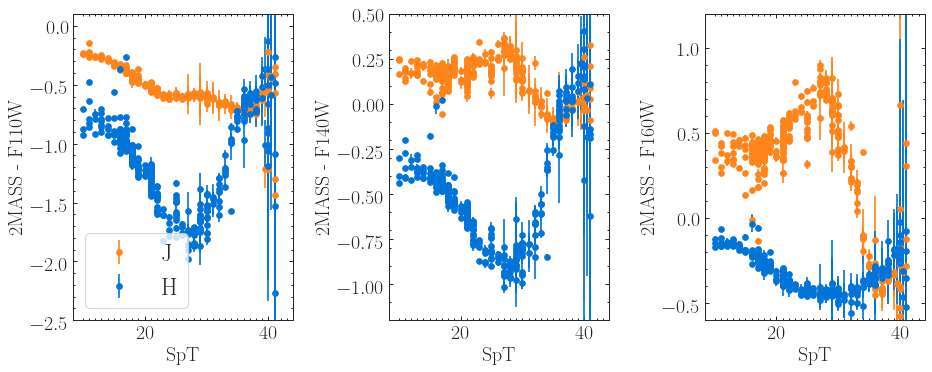

In [24]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 5), sharey=False)
for a in ax:
    a.set_xlabel('SpT')

ax[0].set_ylabel('2MASS - F110W')
ax[0].errorbar(sp_grid, colors[:,0][:,0], yerr= uncolors[:,0][:,0], label='J',fmt='o', c='#FF851B', ms=5)
ax[0].errorbar(sp_grid, colors[:,0][:,1], yerr=uncolors[:,0][:,1],  label='H',fmt='o', c='#0074D9', ms=5)

ax[1].set_ylabel('2MASS - F140W')
ax[1].errorbar(sp_grid, colors[:,1][:,0], yerr=uncolors[:,1][:,0], label='J',fmt='o', c='#FF851B', ms=5)
ax[1].errorbar(sp_grid, colors[:,1][:,1], yerr=uncolors[:,1][:,1], label='H',fmt='o', c='#0074D9', ms=5)

ax[2].set_ylabel('2MASS - F160W')
ax[2].errorbar(sp_grid, colors[:,2][:,0], yerr=uncolors[:,2][:,0], label='J',fmt='o', c='#FF851B', ms=5)
ax[2].errorbar(sp_grid, colors[:,2][:,1], yerr=uncolors[:,2][:,1], label='H',fmt='o', c='#0074D9', ms=5)

ax[0].legend()

for a in ax:
    a.set_xticks(np.arange(10, 45, 1), minor=True)
    a.set_yticks(np.arange(-3, 1.0, 0.1), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_ylim([-2.5, 0.1])
ax[1].set_ylim([-1.2, 0.5])
ax[2].set_ylim([-0.6, 1.2])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mass_hubble_colors.pdf')

### Generate apparent HST mags<br>
Using candidates?

In [25]:
def absolute_mag_relation(spt):
    spt=wisps.make_spt_number(spt)
    j, h= make_mamajek_fit(spt)
    #try dupuy up to T7
    if (spt > 37):
        h=absolute_mag_kirkpatrick(spt, '2MASS H')
        j, _= make_mamajek_fit(spt)
    if spt< 15:
         j, h= make_mamajek_fit(spt)
    return [j, h]

In [26]:
jhsmamj=np.vstack([ absolute_mag_relation(x) for x in sp_grid])

In [27]:
js=jhsmamj[:,0]
hs=jhsmamj[:,1]

In [28]:
js_best=[absolute_mag_best(x, '2MASS J') for x in sp_grid]
hs_best=[absolute_mag_best(x, '2MASS H') for x in sp_grid]

In [29]:
js_dupuy=[absolute_mag_dupuy(x, '2MASS J') for x in sp_grid]
hs_dupuy=[absolute_mag_dupuy(x, '2MASS H') for x in sp_grid]

In [30]:
abs_hstmagsj=np.array([np.array(js)-x for x  in colors[:, :,0].T]).T
abs_hstmagsh=np.array([np.array(hs)-x for x  in colors[:, :,1].T]).T

In [31]:
abs_hstmagsjunc=(uncolors[:, :, 0]**2+0.4**2)**0.5 #the intrinsic scatter is not the std
abs_hstmagshunc=(uncolors[:, :, 1]**2+0.4**2)**0.5 #the instrinsic scatter is but the mean of errors

In [32]:
def get_app_hst_mag(dist, absmag):
    ##returns apparent HST mag given distance and absolute mag
    return np.log10(dist-1)*5+absmag

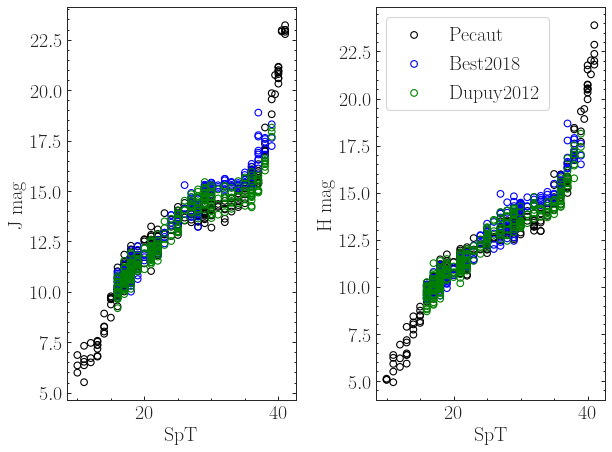

In [33]:
fig, ax=plt.subplots(ncols=2)

ax[0].scatter(sp_grid, js, edgecolor='k', facecolor='', label='Pecaut')
ax[0].scatter(sp_grid, js_best, edgecolor='b', facecolor='', label='Best2018')
ax[0].scatter(sp_grid, js_dupuy, edgecolor='g', facecolor='', label='Dupuy2012')

ax[0].set_xlabel('SpT', fontsize=18)
ax[0].set_ylabel('J mag', fontsize=18)

ax[1].scatter(sp_grid, hs, edgecolor='k', facecolor='', label='Pecaut')
ax[1].scatter(sp_grid, hs_best, edgecolor='b', facecolor='', label='Best2018')
ax[1].scatter(sp_grid, hs_dupuy, edgecolor='g', facecolor='', label='Dupuy2012')

ax[1].set_xlabel('SpT', fontsize=18)
ax[1].set_ylabel('H mag', fontsize=18)

ax[1].legend(fontsize=18)

for a in ax:
    a.minorticks_on()
    
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/abs_mag_comparison.pdf', bbox_inches='tight')

## Visualization

In [34]:
#use kirkpatrick relations for y dwarfs points

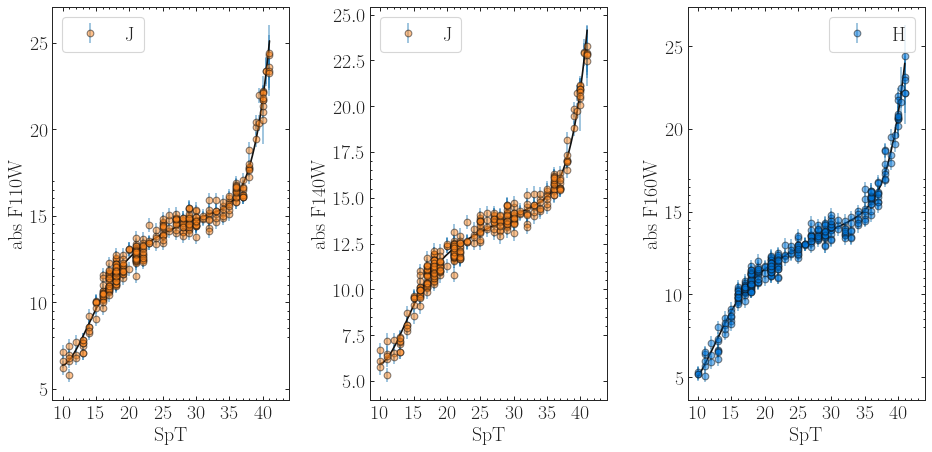

In [35]:
fig, ax=plt.subplots(ncols=3, sharey=False, figsize=(12, 6))
for a in ax:
    a.set_xlabel('SpT')

#ax[0].plot( sp_grid, np.array(js))
#ax[1].plot( sp_grid, np.array(hs))

#ax[0].set_ylabel('abs J')
#ax[1].set_ylabel('abs H')

ax[0].errorbar( sp_grid, abs_hstmagsj[:,0], yerr=abs_hstmagsjunc[:,0], fmt='o',  mec='#111111', mfc='#FF851B', label='J', alpha=0.5)
ax[1].errorbar( sp_grid, abs_hstmagsj[:,1], yerr=abs_hstmagsjunc[:,1], fmt='o',  mec='#111111',  mfc='#FF851B', label='J', alpha=0.5)

ax[2].errorbar(sp_grid, abs_hstmagsh[:,2], yerr=abs_hstmagshunc[:, 2],fmt='o',mec='#111111',  mfc='#0074D9', label='H', alpha=0.5)

ax[0].set_ylabel('abs F110W')
ax[1].set_ylabel('abs F140W')
ax[2].set_ylabel('abs F160W')


grids=np.linspace(np.nanmin(sp_grid), np.nanmax(sp_grid), 1000)

SIGMA0=np.nanmean(abs_hstmagsjunc[:,0])

nanidx4=np.isnan( abs_hstmagsj[:,0])
p4=wisps.fit_polynomial( sp_grid[~nanidx4], (abs_hstmagsj[:,0])[~nanidx4], n=6, y_unc=(abs_hstmagsjunc[:,0])[~nanidx4])
ax[0].plot(grids, p4(grids), c='#111111')
#ax[0].fill_between(grids, p4(grids)+SIGMA0, p4(grids)-SIGMA0, alpha=0.1)

nanidx5=np.isnan( abs_hstmagsj[:,1])
SIGMA1=np.nanmean(abs_hstmagsjunc[:,1])
p5=wisps.fit_polynomial(sp_grid[~nanidx5], (abs_hstmagsj[:,1])[~nanidx5], n=6,  y_unc=(abs_hstmagsjunc[:,1])[~nanidx5])
ax[1].plot( grids, p5(grids),c='#111111')
#ax[1].fill_between(grids, p5(grids)+SIGMA1, p5(grids)-SIGMA1, alpha=0.1)

SIGMA2=np.nanmean(abs_hstmagshunc[:,2])

nan160=np.isnan(abs_hstmagsh[:,2])
p6=wisps.fit_polynomial( sp_grid[~nan160], (abs_hstmagsh[:,2])[~nan160], n=6,  y_unc=(abs_hstmagshunc[:,2])[~nan160])
ax[2].plot( grids, p6(grids),  c='#111111')
#ax[2].fill_between(grids, p6(grids)+SIGMA2, p6(grids)-SIGMA2, alpha=0.1 )



for a in ax:
    a.set_xticks(np.arange(10, 45, 1), minor=True)
    a.set_xticks(np.arange(10, 45, 5), minor=False)
    a.set_yticks(np.arange(8, 17.5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
    a.legend(fontsize=18)
    #a.set_xlim([15, 42.5])

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/hst_relations.pdf')

In [36]:
#app_hstmags[:,2].shape

In [37]:
#fig, ax=plt.subplots(ncols=3, figsize=(12, 3), sharex=True)
#for a in ax:
#    a.invert_yaxis()
#    a.set_xscale('log')
#for i in np.arange(0, 18):
#    ax[0].plot(ds, np.array(app_hstmags)[:,i][0], color='#0074D9', alpha=0.4)
#    ax[1].plot(ds, np.array(app_hstmags)[:,i][1],  color='#0074D9', alpha=0.4)
#    ax[2].plot(ds, np.array(app_hstmags)[:,i][2],  color='#0074D9', alpha=0.4)

#ax[0].set_xlabel('distance (pc)')
#ax[1].set_xlabel('distance (pc)')
#ax[2].set_xlabel('distance (pc)')

#ax[0].set_ylabel('F110W')
#ax[1].set_ylabel('F140W')
#ax[2].set_ylabel('F160W')
#plt.tight_layout()

## Using my sample to map to SNR and sigma_error on app mags

In [38]:
import wisps

In [39]:
from astropy.table import Table
tab = Table.read(wisps.LIBRARIES+'/candidates.tex').to_pandas()

In [40]:
cands=tab

In [41]:
cands.columns

Index(['Shortname', 'grism id', 'snrj', 'spt', 'ra', 'dec', 'f110', 'f110\_er',
       'f140', 'f140\_er', 'f160', 'f160\_er', 'distance', 'distance\_er',
       '2MASS j', '2MASS h\_ER', '2MASS j\_ER'],
      dtype='object')

In [42]:
#some reformatting
obs_F110W=np.array([cands.f110.values, cands['f110\_er'].values ]).T
obs_F140W=np.array([cands.f140.values, cands['f140\_er'].values ]).T
obs_F160W=np.array([cands.f160.values, cands['f160\_er'].values ]).T

In [43]:

mags=np.linspace(10, 27, 100)

In [44]:
snrs=cands.snrj.values

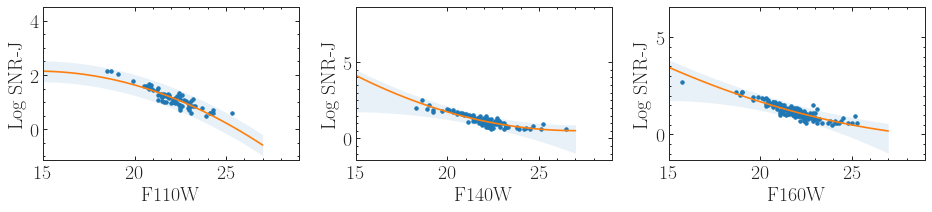

In [45]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 3))

for a in ax:
    a.set_ylabel(r'Log SNR-J')
    a.set_xlim([15, 27])
    #a.set_ylim([0, 500])

ax[0].plot(obs_F110W[:,0], np.log10(snrs), '.')
ax[1].plot(obs_F140W[:,0], np.log10(snrs), '.')
ax[2].plot(obs_F160W[:,0], np.log10(snrs), '.')


p0=wisps.fit_polynomial(obs_F110W[:,0], np.log10(snrs), n=2, sigma_clip=True, sigma=5)
ax[0].plot(mags, p0(mags))
ax[0].fill_between(mags, p0(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )


p1=wisps.fit_polynomial(obs_F140W[:,0], np.log10(snrs), n=2,  sigma_clip=True, sigma=5)
ax[1].plot(mags, p1(mags))
ax[1].fill_between(mags, p1(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )


p2=wisps.fit_polynomial(obs_F160W[:,0], np.log10(snrs), n=2,  sigma_clip=True, sigma=5)
ax[2].plot(mags, p2(mags))
ax[2].fill_between(mags, p2(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )

for a in ax:
    a.set_xticks(np.arange(20, 30, 1), minor=True)
    a.set_yticks(np.arange(-1, 5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[2].set_xlabel('F160W')

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/snr_fits.pdf')

In [46]:
polrealtions={'snr_F110W':p0, 'snr_F140W':p1, 'snr_F160W':p2, \
             'sp_F110W':p4, 'sigma_log_f110':  np.std(np.log10(snrs)),
              'sigma_log_f140':  np.std(np.log10(snrs)),
              'sigma_log_f160':  np.std(np.log10(snrs)),
              'sp_F140W':p5, 'sigma_sp_F140W':SIGMA1, 'sp_F160W':p6, 
              'sigma_sp_F160W':SIGMA2,
             'sigma_sp_F110W':SIGMA0 }